In [2]:
%matplotlib inline
import warnings
## scipy gives a waring when reading wav file
warnings.filterwarnings('ignore')

import scipy as sp
import scipy.io.wavfile
import scipy.signal
import numpy as np
from matplotlib import pyplot as plt

np.set_printoptions(suppress=True)

lenght of audio 127101024
data space size 400 by 639 totalling 255600


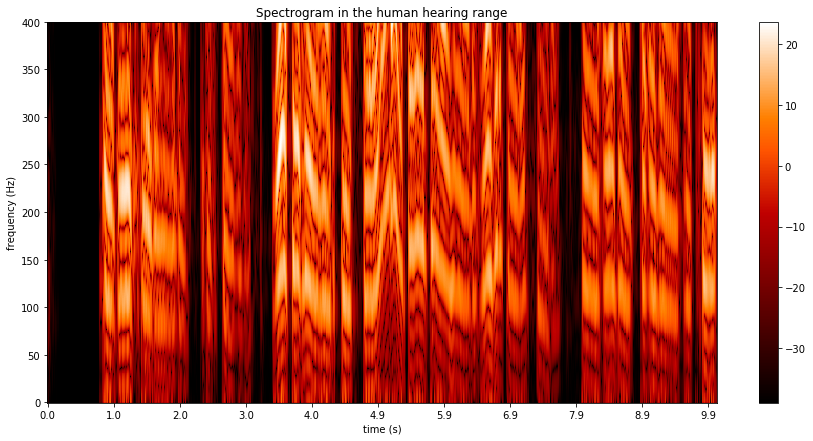

In [3]:
import importlib
from tools import tools
from matplotlib import pyplot as plt
import importlib
importlib.reload(tools)

# sample_rate, wav_data = scipy.io.wavfile.read("audio-files/kombucha.wav")
sample_rate, wav_data = sp.io.wavfile.read("audio-files/radiolab_crispr.wav")
# sample_rate, wav_data = sp.io.wavfile.read("audio-files/relief.wav")

# filtering out commercials
start_point = 200 * sample_rate

## taking just one channel
audio_data = wav_data[:, 1]
audio_data = audio_data[start_point:]

    
segment_length = int(sample_rate/32)
overlap = int(segment_length / 2)
freq_bins, time_points, spectrogram = tools.generateSpectrogram(
    audio_data, segment_length, sample_rate, overlap, 2000, 10)
specdb = tools.todB(spectrogram + 1)

specdb = specdb[0:400]
# plotting
f = tools.plotSpectrogram(specdb, time_points)

# additional info
dbmax, dbmin = np.max(specdb), np.min(specdb)
dbrange = dbmax - dbmin
print("lenght of audio", len(audio_data))
print("data space size", specdb.shape[0], "by", specdb.shape[1], "totalling", specdb.shape[0] * specdb.shape[1], )

drew 1266 out of 10000 -- 0.1266


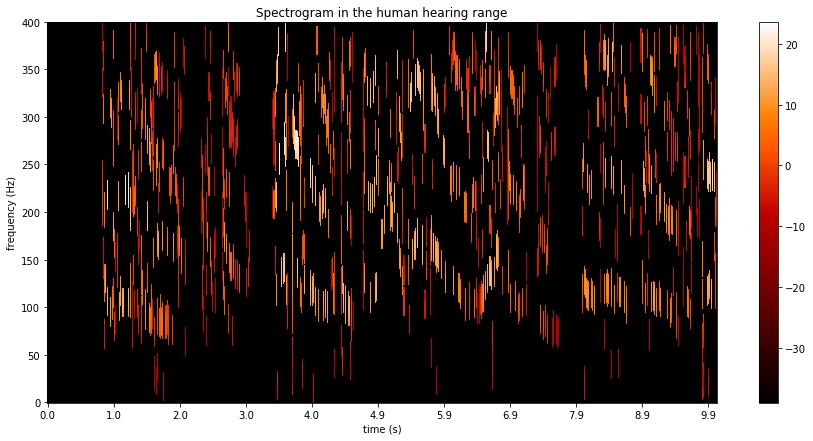

In [76]:
importlib.reload(tools)
from shapely.geometry import LineString
## redrawing with lines

# def coord_function(x1, y1, x2, y2):
#     slope = (y2 - y1) / (x2 - x1)
#     def coord(x):
#         print(x)
#         if (x > x2):
#             raise Exception("x is more than the final x2")
#         return int(np.rint(y1 + x * slope))
#     return coord

a_deg = 90
a = a_deg * np.pi / 180
d = 30
num_samples = 10000
limitx, limity = specdb.shape[1], specdb.shape[0]
sd_limu, sd_liml = 1.5, 0.0
mean_limu, mean_liml = 100, -10

sample_sd = np.empty(num_samples)
sample_mean = np.empty(num_samples)
draw_space = np.full(specdb.shape, dbmin)
lines_drawn, lines_analysed = 0, 0

analysing = False

for i in range(num_samples):
    th_x = np.rint(d * np.cos(a))  # theta
    th_y = np.rint(d * np.sin(a))

    lx_low = tools.zero_or_below(th_x)  # only an issue if left directed
    lx_high = limitx - tools.zero_or_above(th_x)
    ly_low = tools.zero_or_below(th_y)
    ly_high = limity - tools.zero_or_above(th_y)
        
    x1 = int(np.around(np.random.randint(lx_low, lx_high)))
    y1 = int(np.around(np.random.randint(ly_low, ly_high)))
    x2 = int(x1 + th_x)
    y2 = int(y1 + th_y)
    
    sample = np.empty(d+1)
    
    line = LineString([(x1,y1), (x2,y2)])
    specdb_slice = specdb[y1:y2+1,x1:x2+1]
    for j in range(d+1):
        c = line.interpolate(j/d, normalized=True)
        sample[j] = specdb_slice[int(c.y - y1), int(c.x - x1)]
    
    # analysis
    sd, mean = np.std(sample), np.mean(sample)
    
    sample_sd[i] = sd
    sample_mean[i] = mean

    if not analysing:
        within_limit = (sd < sd_limu) & (sd > sd_liml) & (mean < mean_limu) & (mean > mean_liml)
        if within_limit:
            lines_drawn += 1
            for j in range(d+1):
                c = line.interpolate(j/d, normalized=True)
                draw_space[int(c.y), int(c.x)] = specdb[int(c.y), int(c.x)]
#                 draw_space[int(c.y), int(c.x)] = 1
    
if analysing:
    fig = plt.figure(figsize=(15,10))
    ssd, sm = sample_sd[sample_sd > 0.01], sample_mean[sample_sd > 0.01]
    ssd, sm = ssd[sm > -35], sm[sm > -35]
    
    plt.hexbin(ssd, sm)
    plt.colorbar(orientation='vertical')
    print("analysed", lines_analysed, "out of", num_samples, "--", lines_analysed/num_samples)
    print(np.max(sample_mean))

if not analysing:
    f = tools.plotSpectrogram(draw_space, time_points)
    print("drew", lines_drawn, "out of", num_samples, "--", lines_drawn/num_samples)